In [ ]:
!git clone https://github.com/JarvisSan22/Unet_CrackExtract_to_dxf.git

In [9]:
import os 
import glob
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 訓練のデータを作成する


* Unetは訓練の画像は、普通な画像とGroundTruthという画像に分かれています。亀裂の画像の場合は、GroundTruthの場合は、亀裂の位置や範囲に白い塗り、残っている画像が白いに表しています。

* その訓練の画像のサイズは、(258,258)以内にお勧めします。大きな画像の場合は、このコードには、分ける機能があります(SPLIT=Trueを設定してください)。

<h3> 正しい訓練データの例　参考 DeepCrackというデータセット
* 1 画像

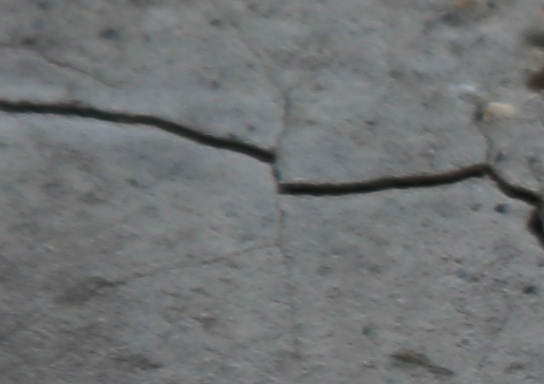
* 1 黒白の画像 -> Ground Truth 

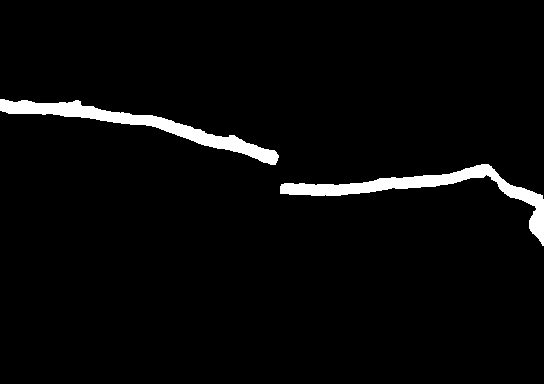





上記の画像のデータは、下記のようなダイレクトりの仕組みに保存する。
```bash
-train
  |-iamge
  |  |- 001.png
  |  |- 002.png
  |  |- 003.png
  |  |- .....
  |-label
    |- 001.png
    |- 002.png
    |- 003.png
    |- .....
-test
 |- 001.png 
 |- 002.png
 |- 003.jpg
 

```

### 処理する画像の保存先

In [10]:
base_dataset=""
data_path=f"{base_dataset}/train/" #画像の保存先
images=glob.glob(data_path+"D-***") #普通の画像
images_W=glob.glob(data_path+"DW-***") #画像と輪郭  <- 確認するために、使用しています
Labels=glob.glob(data_path+"DWB-***") #白黒の画像 Ground truth

##設定

In [23]:
#保存したい画像のサイズ
IMG_WIDTH=258
IMG_HEIGHT=258
IMG_SIZE=(IMG_HEIGHT,IMG_WIDTH)

In [25]:
#画像の大きさ
image_1=imread(images[0])
image_w=imread(images_W[0])
w,h,c=image_1.shape
print(w,h,c)

lim=4
SPLIT=False #
if (w//IMG_WIDTH>lim) or (h//IMG_HEIGHT>lim):
  print("Split set to true")
  SPLIT=True

7738 4240 3
Split set to true


In [12]:
#テスト画像の表示する
label=cv2.imread(Labels[0],0)
label.shape
len(label[label<=32]),len(label[label>32])
ret,thresh = cv2.threshold(label,33,256,cv2.THRESH_BINARY) 

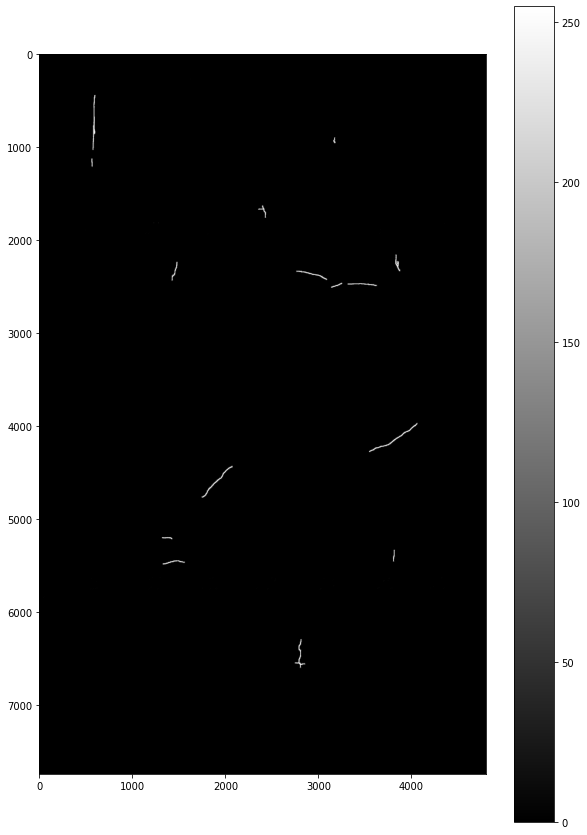

In [19]:
plt.figure(figsize=(10,15))
im=plt.imshow(thresh,"gray")
plt.colorbar(im)

In [27]:
def create_tiles(img,IMAGE_SIZE=(IMG_HEIGHT,IMG_WIDTH,1)): 

  IMAGE_H=IMAGE_SIZE[0]
  IMAGE_W=IMAGE_SIZE[1]
  M=img.shape[0]//(w//IMAGE_W)
  N=img.shape[1]//(h//IMAGE_H)
  #print(M,N)
  tiles = [cv2.resize(img[x:x+M,y:y+N],(IMAGE_H,IMAGE_W)) for x in range(0,img.shape[0],M) for y in range(0,img.shape[1],N)]
  locs=  [[x,y] for x in range(0,img.shape[0],M) for y in range(0,img.shape[1],N)]
  return tiles,locs
  
def label_tiles_create(label_file):
  label=cv2.imread(label_file,0) #グレースケールで画像を読み込む
  #cv2.threshhold(画像,最低のしきい、最高のしきい,しきいの処理の種類）
  ret,thresh = cv2.threshold(label,33,256,cv2.THRESH_BINARY) #しきい値処理（黒は０ではない場合は、必要です。）
  #訓練のデータを作成
  h,w=label.shape
  #mask=np.zeros((h,w,1),dtype=np.bool)
  #mask_=np.expand_dims(thresh,axis=-1)
  #mask=np.maximum(mask,mask_)
  thresh=cv2.GaussianBlur(thresh,(3,3), 1)
  #画像を分ける
  L_tiles,L_locs=create_tiles(thresh ) #mask)
  return L_tiles,L_locs




In [29]:
L_save={} #Image Save
I_save={} #Label Save
C_save={} #Check save
#For Split Splitの場合
Locs_save={}
#Save location #保存先
savedir=f"{base_dataset}/
if not os.path.exists(savedir+"label"):
  os.mkdir(savedir+"label")
if not os.path.exists(savedir+"image"):
  os.mkdir(savedir+"image")

#正しいファイルの順番
Labels=sorted(Labels)
images_W=sorted(images_W)
images=sorted(images)
i=1
for label,image_w,image in zip(Labels,images_W,images):

  if SPLIT:
    L_tiles,L_locs=label_tiles_create(label)
    L_images,L_locs=create_tiles(cv2.imread(image))
    L_images_W,L_locs=create_tiles(cv2.imread(image_w))
    for j in range(0,len(L_tiles)):
      if np.any(L_tiles[j]>0): #すべてゼロではない
      #画像のエラーの対策　（小さいな白いピクセル）
        if np.shape(np.nonzero(L_tiles[j]))[1]>1000:
          img_name="%003d.png" % i
          i+=1
          label_save=savedir+"label/"+img_name
          L_save[label_save]=L_tiles[j]
          cv2.imwrite(label_save,L_tiles[j])

          image_save=savedir+"image/"+img_name
          I_save[image_save]=L_images[j]
          cv2.imwrite(image_save,L_images[j])
          Locs_save[img_name]=L_locs[j]
  
  else:
    img_name="%003d.png" % i
    i+=1
    label_save=savedir+"label/"+img_name
    label=cv2.resize(label,IMG_SIZE)
    L_save[label_save]=label
    cv2.imwrite(label_save,label)
   
    image_save=savedir+"image/"+img_name
    image=cv2.resize(image,IMG_SIZE)
    I_save[image_save]=images
    cv2.imwrite(image_save,images)

  
print(len(L_save),len(I_save))
    


319 319


#テストのデータ

In [ ]:
data_path=f"{base_dataset}/train/"

images=glob.glob(data_path+"D-***")

T_save={} #Image Save
Locs_save={}
savedir=f"{base_dataset}/test/"

i=1
#正しいファイルの順番
images=sorted(images)

for image in images:
  
  if SPLIT:

    L_images,L_locs=create_tiles(cv2.imread(image))
    for j in range(0,len(L_images)):
        img_name="%003d.png" % i
        i+=1
        image_save=savedir+img_name
        T_save[image_save]=L_images[j]
        cv2.imwrite(image_save,L_images[j])
        Locs_save[img_name]=L_locs[j]
    else:
      img_name="%003d.png" % i
      i+=1
      image=cv2.resize(image,IMG_SIZE)
      image_save=savedir+img_name
      T_save[image_save]=image
      cv2.imwrite(image_save,images)

    
print(len(I_save))
    


/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/step2/train/D-001.jpg
257 235
/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/step2/train/D-002.jpg
257 266
/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/step2/train/D-003.jpg
257 266
/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/step2/train/D-004.jpg
257 266
/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/step2/train/D-005.jpg
257 266
/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/step2/train/D-006.jpg
257 266
/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/step2/train/D-007.jpg
257 266
/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/step2/train/D-008.jpg
257 266
/content/drive/MyDrive/Colab Notebooks/AI/crack_model/data/step2/train/D-009.jpg
257 266
5625
